In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Problem

### Ideation

- This is common multi-class classification problem
- The approach should be:
    - Starts with Data Exploration to understand the dataset
    - Answer some questions, for example: is this balanced or imbalanced classification problem? what is the co-relation between the target with other columns
    - Pickup the right algorithms: could be simple with Decision Tree to more complex like Random Forest or Boosting Tree ...

### 1. EDA

In [2]:
cols = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

data = pd.read_csv('./data/car.data', header=None, names=cols)

- Target column is `buying`

In [3]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
data.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


- simple stats

In [8]:
data['buying'].value_counts()

vhigh    432
high     432
med      432
low      432
Name: buying, dtype: int64

#### Notes: the distribution of `buying` is equally - very balanced dataset

- Look at some relationship between `buying` vs `other columns`

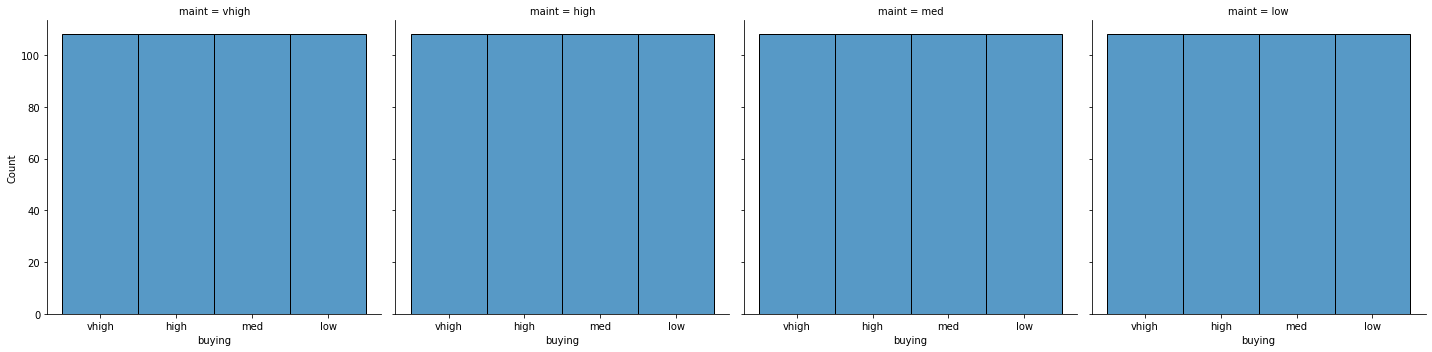

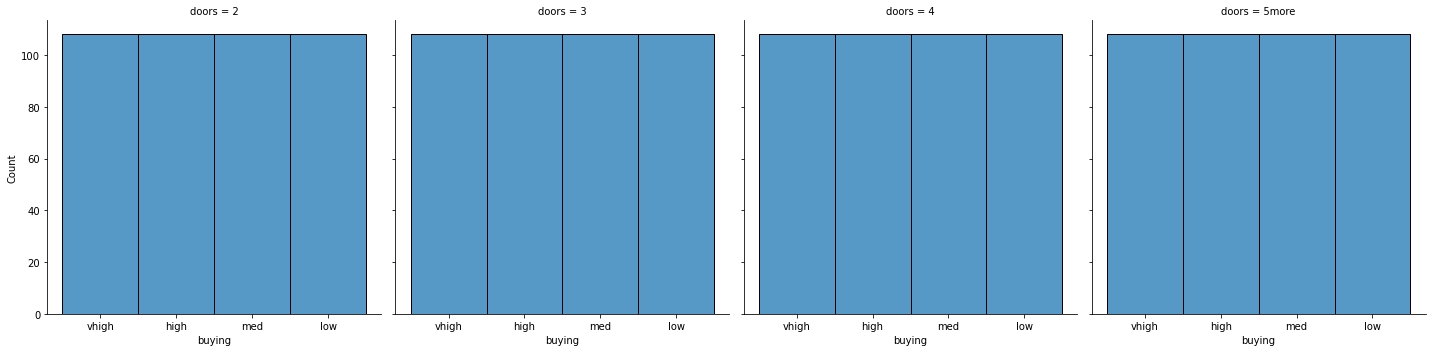

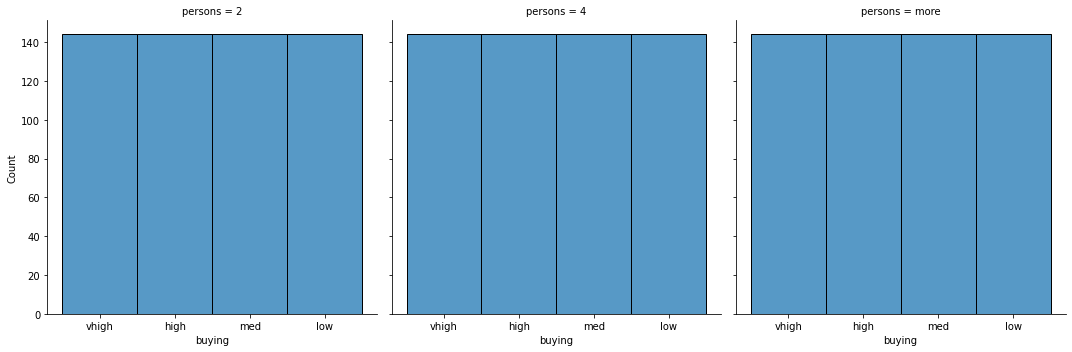

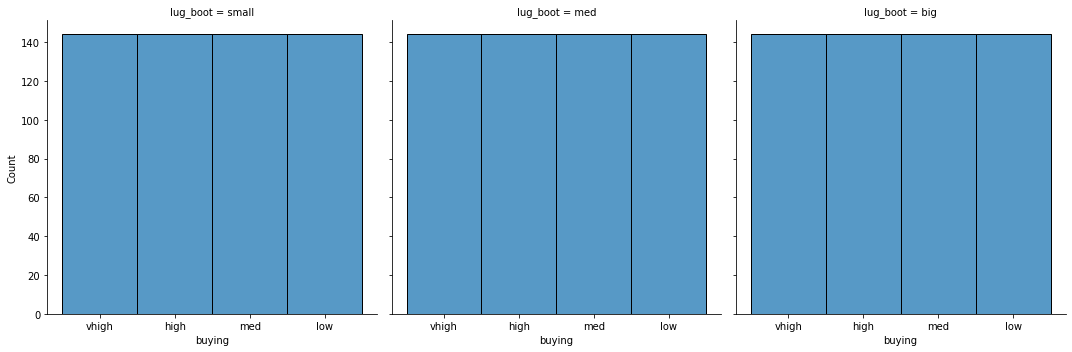

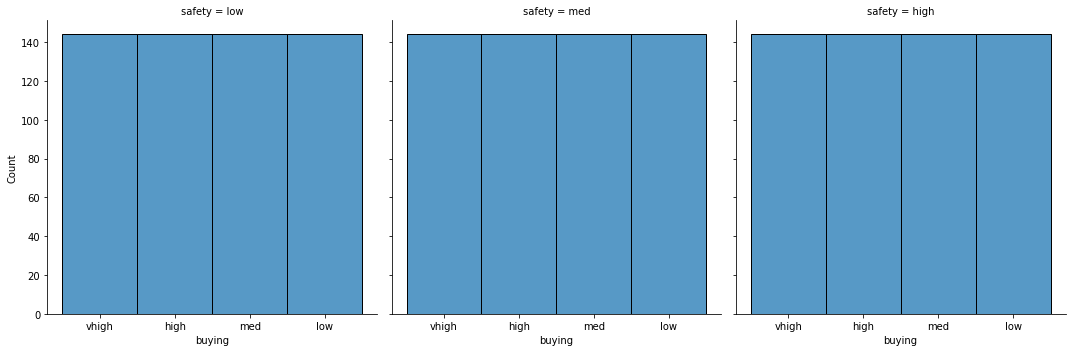

In [16]:
for col in ['maint', 'doors', 'persons', 'lug_boot', 'safety']:
    sns.displot(data, x="buying", col=col);

- Distribution of `buying` look pretty the same for `['maint', 'doors', 'persons', 'lug_boot', 'safety']`. These features might not be important to the model

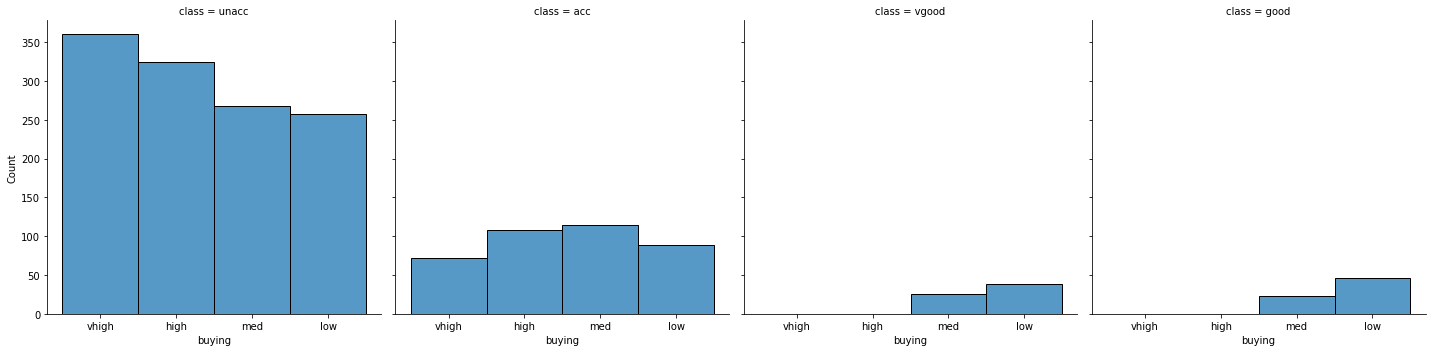

In [10]:
sns.displot(data, x="buying", col="class");

- Distribution of `buying` is significant across different `class`. This could be the main factor to contribute to the model

- We could bindly say that if `class = good` or `class = vgood`, the `buying` will highly be `med` or `low`

### 2. Modelling

- Feature engineering

- Since all of columns are categorical, `OneHotEncoding` would be the right choice to covert data to numeric matrix
- `buying` is multi-class target, `LabelEncoding` would be used to normalize

In [22]:
import pickle

In [17]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [131]:
X, y = data.drop(['persons', 'buying'], axis=1).copy(), data['buying'].copy()

In [132]:
print(X.shape)
print(y.shape)

(1728, 5)
(1728,)


In [133]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(X)

# dump to pickle 
with open('./model/one_hot_endcoder.pkl', 'wb') as w:
    pickle.dump(one_hot_encoder, w)

In [134]:
label_encoder = LabelEncoder()
label_encoder.fit(y)

# dump to pickle 
with open('./model/label_encoder.pkl', 'wb') as w:
    pickle.dump(label_encoder, w)

In [135]:
X_transformed = one_hot_encoder.transform(X)
y_transformed = label_encoder.transform(y)

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.3, random_state=2023, stratify=y_transformed)

In [138]:
print("Train: ", X_train.shape, y_train.shape)
print("Train: ", X_test.shape, y_test.shape)

Train:  (1209, 18) (1209,)
Train:  (519, 18) (519,)


- Build a dump model

In [139]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [140]:
def model_summary(model, X_test, y_test):
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

In [141]:
one_hot_encoder.get_feature_names_out()

array(['maint_high', 'maint_low', 'maint_med', 'maint_vhigh', 'doors_2',
       'doors_3', 'doors_4', 'doors_5more', 'lug_boot_big',
       'lug_boot_med', 'lug_boot_small', 'safety_high', 'safety_low',
       'safety_med', 'class_acc', 'class_good', 'class_unacc',
       'class_vgood'], dtype=object)

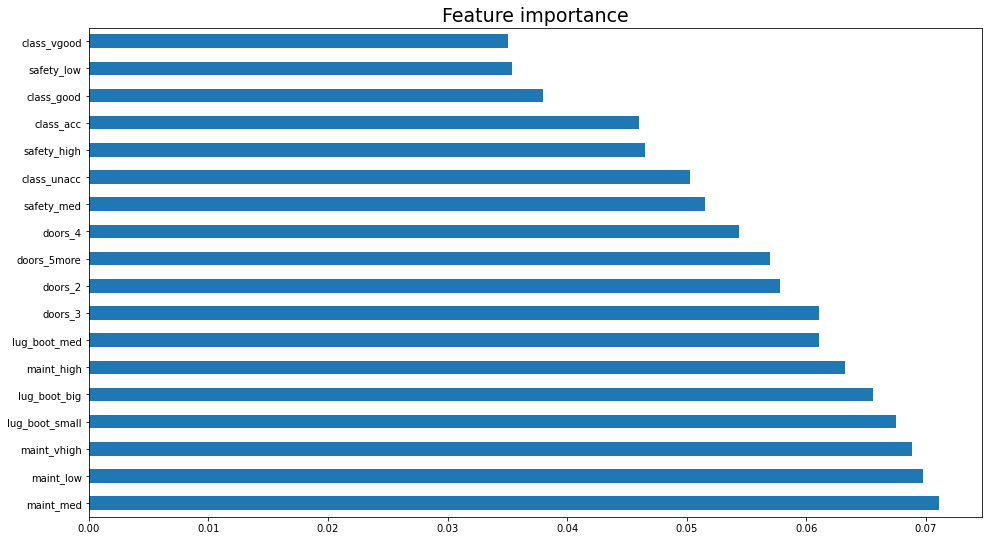

In [142]:
rf_tree = RandomForestClassifier()
rf_tree.fit(X_train, y_train)

plt.figure(figsize=(16, 9))
plt.title("Feature importance", fontsize=19)
feat_importances = pd.Series(rf_tree.feature_importances_, index=one_hot_encoder.get_feature_names_out())
feat_importances.nlargest(21).plot(kind='barh')
plt.show()

In [143]:
model_summary(rf_tree, X_train, y_train)

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       302
           1       0.49      0.44      0.46       302
           2       0.40      0.47      0.43       303
           3       0.44      0.47      0.46       302

    accuracy                           0.44      1209
   macro avg       0.44      0.44      0.44      1209
weighted avg       0.44      0.44      0.44      1209



In [144]:
model_summary(rf_tree, X_test, y_test)

              precision    recall  f1-score   support

           0       0.14      0.12      0.12       130
           1       0.21      0.20      0.20       130
           2       0.09      0.09      0.09       129
           3       0.19      0.23      0.21       130

    accuracy                           0.16       519
   macro avg       0.16      0.16      0.16       519
weighted avg       0.16      0.16      0.16       519



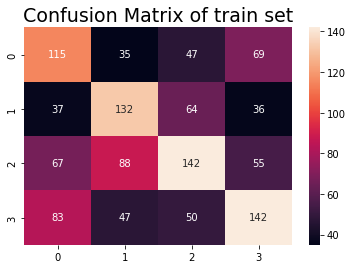

In [145]:
# Let see the confusion matrix
matrix = pd.DataFrame(confusion_matrix(rf_tree.predict(X_train), y_train))

plt.title('Confusion Matrix of train set', fontsize=19)
sns.heatmap(matrix, annot=True, fmt='d');

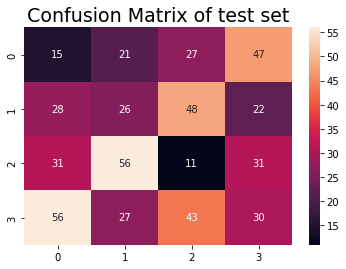

In [146]:
matrix = pd.DataFrame(confusion_matrix(rf_tree.predict(X_test), y_test))

plt.title('Confusion Matrix of test set', fontsize=19)
sns.heatmap(matrix, annot=True, fmt='d');

- This dump model perform fine in `train set` but very bad in `test set`

- Hyperparameter Tunning (Simple GridSearch)

In [148]:
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([('clf', RandomForestClassifier(random_state=2023))])
parameters = {
'clf__n_estimators': [10],
'clf__max_depth': [3],
'clf__min_samples_split': (0.2, 0.5),
}

grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1,verbose=1, scoring='f1_micro')
grid_search.fit(X_train, y_train)
print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)
print(classification_report(y_test, predictions))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.288
Best parameters set:
	clf__max_depth: 3
	clf__min_samples_split: 0.2
	clf__n_estimators: 10
              precision    recall  f1-score   support

           0       0.28      0.32      0.30       130
           1       0.67      0.24      0.35       130
           2       0.29      0.26      0.27       129
           3       0.30      0.49      0.37       130

    accuracy                           0.33       519
   macro avg       0.39      0.33      0.32       519
weighted avg       0.39      0.33      0.32       519



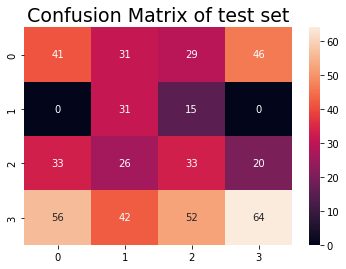

In [149]:
matrix = pd.DataFrame(confusion_matrix(grid_search.predict(X_test), y_test))

plt.title('Confusion Matrix of test set', fontsize=19)
sns.heatmap(matrix, annot=True, fmt='d');

- Save the best model

In [168]:
with open('./model/best_model.pkl', 'wb') as w:
    pickle.dump(grid_search, w)

- Dump `train`, `test` set

In [169]:
with open('./data/train.pkl', 'wb') as w:
    pickle.dump((X_train, y_train), w)
    
with open('./data/test.pkl', 'wb') as w:
    pickle.dump((X_test, y_test), w)

### 3. Prediction

In [182]:
def do_predict(maint, doors, lug_boot, safety, clazz):
    input_data = pd.DataFrame([[maint.lower(), doors.lower(), lug_boot.lower(), safety.lower(), clazz.lower()]], columns=['maint','doors','lug_boot','safety','class'])
    
    with open('./model/one_hot_endcoder.pkl', 'rb') as r:
        one_hot_endcoder = pickle.load(r)
    with open('./model/label_encoder.pkl', 'rb') as r:
        label_encoder = pickle.load(r)
    with open('./model/best_model.pkl', 'rb') as r:
        model = pickle.load(r)
        
    X = one_hot_encoder.transform(input_data)
    prediction = model.predict(X)
    score = model.predict_proba(X)[0][prediction][0]
    
    return {'buying': label_encoder.inverse_transform(prediction)[0], 'score': score}

In [183]:
do_predict('High', '4', 'Big', 'High', 'Good')

{'buying': 'low', 'score': 0.4036505585018106}